# Imports

In [1088]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report 
from sklearn.metrics import plot_roc_curve
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.compose import ColumnTransformer
import time
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import Ridge

## Data Import and Cleaning 

### Import Historic Stats

In [1089]:
current_week = int(input("Input Current NFL Week"))
print(current_week)

Input Current NFL Week3
3


In [1090]:
years = [2017, 2018, 2019, 2020, 2021]

In [1091]:
stats_list = []
for year in years:
    if year != 2021:
        for i in range(1,18):
            name = 'Data/Historic_Stats/'+ str(year) + '_' + str(i) + '.csv'
            stats_list.append(name)
    else:
        for i in range(1, current_week):
            name = 'Data/Historic_Stats/'+ str(year) + '_' + str(i) + '.csv'
            stats_list.append(name)

In [1092]:
stats_list[0][-10:-6]

'2017'

In [1093]:
len('Data/Historic_Stats/2017_10.csv')

31

In [1094]:
historic_stats = pd.DataFrame()
for index, item in enumerate(stats_list):
    df = pd.read_csv(item)
    df = df[['Name', 'Team', 'Week', 'Opponent', 'FantasyPointsPerGameFanDuel', 'FantasyPointsFanDuel']]
    df = df.rename(columns={'FantasyPointsPerGameFanDuel':'FPPG', 'FantasyPointsFanDuel':'Points_Scored'})
    if len(item) == 30:
        df['Year'] = item[-10:-6]
    else: 
        df['Year'] = item[-11:-7]
    historic_stats = historic_stats.append(df)

In [1095]:
historic_stats['Year'].value_counts()

2020    19876
2017    19318
2019    19147
2018    19105
2021     2498
Name: Year, dtype: int64

### Import Historic Projections 

In [1096]:
proj_list = []
for year in years:
    if year != 2021:
        for i in range(1,18):
            name = 'Data/Historic_Proj/'+ str(year) + '_' + str(i) + '.csv'
            proj_list.append(name)
    else:
        for i in range(1, current_week):
            name = 'Data/Historic_Proj/'+ str(year) + '_' + str(i) + '.csv'
            proj_list.append(name)

In [1097]:
len('Data/Historic_Proj/2017_10.csv')

30

In [1098]:
historic_projections = pd.DataFrame()
for item in proj_list:
    df = pd.read_csv(item)
    df = df[['Name', 'Position', 'Week', 'Team','UpcomingOpponentPositionRank', 'FantasyPointsFanDuel', 'OperatorSalary']]
    df = df.rename(columns={'UpcomingOpponentPositionRank':'OPRNK', 'FantasyPointsFanDuel': 'Projected', 'OperatorSalary': 'Salary'})
    if len(item) == 29:
        df['Year'] = item[-10:-6]
    else:
        df['Year'] = item[-11:-7]
    historic_projections = historic_projections.append(df)

In [1099]:
merged_data = historic_stats.merge(historic_projections, how='inner', on=['Name', 'Week', 'Year', 'Team'])

In [1100]:
merged_data

,Name,Team,Week,Opponent,FPPG,Points_Scored,Year,Position,OPRNK,Projected,Salary
0,Kareem Hunt,KC,1,NE,43.1,43.10,2017,RB,3.0,10.73,6400
1,Alex Smith,KC,1,NE,31.0,31.02,2017,QB,11.0,14.69,6900
2,Matthew Stafford,DET,1,ARI,28.1,28.08,2017,QB,12.0,16.13,7600
3,Jacksonville Jaguars,JAX,1,HOU,28.0,28.00,2017,DST,NaN,6.40,4100
4,Los Angeles Rams,LAR,1,IND,28.0,28.00,2017,DST,NaN,7.90,4600
...,...,...,...,...,...,...,...,...,...,...,...
26003,Mitchell Trubisky,BUF,2,MIA,-0.2,-0.20,2021,QB,8.0,0.44,6300
26004,Jordan Love,GB,2,DET,-0.3,-0.30,2021,QB,16.0,0.33,6200
26005,Blaine Gabbert,TB,2,ATL,-0.3,-0.30,2021,QB,28.0,0.31,6000
26006,Detroit Lions,DET,2,GB,-1.0,-1.00,2021,DST,NaN,3.60,3000


In [1101]:
merged_data = merged_data.drop(merged_data[(merged_data['Name'] == 'Chris Thompson') & (merged_data['Team'] == 'HOU')].index)

I noticed there were two Chris Thompsons for 2017 (one on Washington and one on Houston) so I decided to drop the Houston Chris Thompson because it would interfere with the groupbys later in the process

In [1102]:
merged_data = merged_data[merged_data['Position'] != 'DST']
merged_data = merged_data[merged_data['Position'] != 'K']
merged_data = merged_data[merged_data['Position'] != 'LB']
merged_data = merged_data[merged_data['Position'] != 'DB']

In [1103]:
merged_data['Position'].value_counts()

WR    8904
RB    6632
TE    5541
QB    2402
Name: Position, dtype: int64

In [1104]:
merged_data.duplicated().sum()

38

In [1105]:
merged_data = merged_data.drop_duplicates()

In [1106]:
merged_data['Year'].value_counts()

2020    6450
2019    5645
2018    5551
2017    5025
2021     770
Name: Year, dtype: int64

In [1107]:
grouped = merged_data.groupby(['Name','Year','Week']).sum()

It looks like the Fantasy Points Per Game column is just the points scored column right now so we need to calculate that manually

In [1108]:
grouped['Games_Played'] = 1

In [1109]:
new_df = grouped.groupby(level=[0,1]).cumsum().reset_index()

In [1110]:
new_df['Fantasy_PPG'] = round(new_df['Points_Scored'] / new_df['Games_Played'], 1)

In [1111]:
new_df['Fantasy_PPG'] = new_df.groupby(['Name', 'Year'])['Fantasy_PPG'].shift()

In [1112]:
new_df = new_df[['Name', 'Year', 'Week', 'Fantasy_PPG', 'Games_Played']]

In [1113]:
new_df

,Name,Year,Week,Fantasy_PPG,Games_Played
0,A.J. Brown,2019,1,NaN,1
1,A.J. Brown,2019,2,11.5,2
2,A.J. Brown,2019,3,7.8,3
3,A.J. Brown,2019,4,5.5,4
4,A.J. Brown,2019,5,9.8,5
...,...,...,...,...,...
23425,Zay Jones,2020,14,1.9,13
23426,Zay Jones,2020,15,1.8,14
23427,Zay Jones,2020,16,1.8,15
23428,Zay Jones,2020,17,1.7,16


In [1114]:
new_df['FPPG'] = round(new_df.groupby(['Year','Name'])['Fantasy_PPG'].transform(lambda x: x.fillna(x.mean())), 1)

In [1115]:
new_df = new_df.drop('Fantasy_PPG', axis=1)

In [1116]:
new_df = new_df.dropna()

In [1117]:
merged_data = merged_data.drop('FPPG', axis=1)

In [1118]:
merged_data = pd.merge(merged_data, new_df, how='inner', on=['Name','Year','Week'])

In [1119]:
merged_data['Week'].value_counts()

1     1820
2     1817
3     1498
14    1491
15    1478
13    1448
16    1407
4     1398
12    1369
6     1339
10    1283
9     1271
11    1269
17    1177
5     1056
7     1025
8     1022
Name: Week, dtype: int64

In [1120]:
merged_data[merged_data['Name'] == 'Tom Brady']

,Name,Team,Week,Opponent,Points_Scored,Year,Position,OPRNK,Projected,Salary,Games_Played,FPPG
65,Tom Brady,NE,1,KC,10.68,2017,QB,10.0,20.06,8900,1,20.8
363,Tom Brady,NE,2,NO,30.78,2017,QB,27.0,22.17,9200,2,10.7
733,Tom Brady,NE,3,HOU,35.72,2017,QB,5.0,18.70,9400,3,20.7
1130,Tom Brady,NE,4,CAR,20.48,2017,QB,7.0,20.62,9500,4,25.7
1492,Tom Brady,NE,5,TB,13.62,2017,QB,30.0,21.87,9500,5,24.4
...,...,...,...,...,...,...,...,...,...,...,...,...
20160,Tom Brady,TB,12,KC,23.70,2020,QB,11.0,18.80,7900,12,20.5
20954,Tom Brady,TB,14,MIN,15.64,2020,QB,14.0,20.15,7800,13,20.8
21327,Tom Brady,TB,15,ATL,23.40,2020,QB,32.0,20.34,7900,14,20.4
21718,Tom Brady,TB,16,DET,29.92,2020,QB,29.0,21.29,8000,15,20.6


In [1121]:
merged_data['Team'].value_counts().index

Index(['ATL', 'KC', 'BUF', 'DEN', 'SF', 'PIT', 'NE', 'TEN', 'MIA', 'NYJ', 'LV',
       'NO', 'CLE', 'NYG', 'DAL', 'TB', 'GB', 'SEA', 'PHI', 'ARI', 'CAR',
       'CIN', 'IND', 'LAC', 'BAL', 'WAS', 'CHI', 'MIN', 'JAX', 'LAR', 'HOU',
       'DET'],
      dtype='object')

### Merge With Betting Data

In [1122]:
betting_data_home = pd.read_excel('Data/clean_nfl_historic_betting_data.xlsx', sheet_name=3)

In [1123]:
betting_data_away = pd.read_excel('Data/clean_nfl_historic_betting_data.xlsx', sheet_name=2)

In [1124]:
betting_data = pd.concat([betting_data_home, betting_data_away])

In [1125]:
betting_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8110 entries, 0 to 4054
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               8110 non-null   datetime64[ns]
 1   Team               8110 non-null   object        
 2   Line Close         3838 non-null   float64       
 3   Total Score Close  3838 non-null   float64       
 4   Team Proj          3838 non-null   float64       
 5   Week               3838 non-null   float64       
 6   Home / Away        3838 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 506.9+ KB


In [1126]:
betting_data['Year'] = betting_data['Date'].dt.year

In [1127]:
betting_data['Year'] = betting_data['Year'].astype(str)

In [1128]:
betting_data['Year'].value_counts()

2017    566
2012    566
2019    534
2010    534
2016    534
2018    534
2007    534
2008    534
2014    534
2011    534
2013    534
2006    512
2015    502
2020    502
2009    502
2021    153
1905      1
Name: Year, dtype: int64

In [1129]:
betting_data = betting_data[betting_data['Week'] != 0]

In [1130]:
merged_data = merged_data.merge(betting_data, how='inner', on=['Team', 'Week', 'Year'])

In [1131]:
merged_data = merged_data[merged_data['Week'] != 17]

In [1132]:
historic_dome_teams = ['ATL', 'HOU', 'DAL', 'IND', 'ARI', 'NO', 'DET', 'MIN']

In [1133]:
merged_data["Dome"] = np.where((merged_data['Team'].isin(historic_dome_teams)) & (merged_data['Home / Away'] == "Home"), "Dome", np.where((merged_data['Opponent'].isin(historic_dome_teams)) & (merged_data['Home / Away'] == "Away"), "Dome", 'Outside'))

In [1134]:
merged_data['Dome'].value_counts()

Outside    16470
Dome        5523
Name: Dome, dtype: int64

In [1135]:
merged_data = merged_data.rename(columns={'Line Close':'line_close', 'Total Score Close':'over_under'})
merged_data = merged_data.rename(columns={'Team Proj':'team_proj', 'Home / Away':'home_away'})

## Modeling

In [1136]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21993 entries, 0 to 22774
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Name           21993 non-null  object        
 1   Team           21993 non-null  object        
 2   Week           21993 non-null  int64         
 3   Opponent       21993 non-null  object        
 4   Points_Scored  21993 non-null  float64       
 5   Year           21993 non-null  object        
 6   Position       21993 non-null  object        
 7   OPRNK          21974 non-null  float64       
 8   Projected      21974 non-null  float64       
 9   Salary         21993 non-null  int64         
 10  Games_Played   21993 non-null  int64         
 11  FPPG           21993 non-null  float64       
 12  Date           21993 non-null  datetime64[ns]
 13  line_close     21993 non-null  float64       
 14  over_under     21993 non-null  float64       
 15  team_proj      2199

In [1137]:
df = merged_data.copy()

In [1138]:
df['games_missed'] = df['Week'] - df['Games_Played']

In [1139]:
from sklearn.preprocessing import OrdinalEncoder
home = df[['home_away']]
encoder_home = OrdinalEncoder()
encoder_home.fit(home)
home_encoded = encoder_home.transform(home)
home_encoded = home_encoded.flatten()
df['home_away'] = home_encoded

In [1140]:
dome = df[['Dome']]
encoder_dome = OrdinalEncoder()
encoder_dome.fit(dome)
dome_encoded = encoder_dome.transform(dome)
dome_encoded = dome_encoded.flatten()
df['Dome'] = dome_encoded

In [1141]:
df = df.drop('Date', axis=1)

In [1142]:
df = df.dropna()

In [1143]:
categoricals = ['Team', 'Name','Week', 'Opponent', 'Position', 'Year']
df_no_cats = df.drop(categoricals, axis=1)

In [1144]:
df_cats = df[categoricals]
df_cats = df_cats.drop('Year', axis=1)

In [1145]:
df_no_cats['Points'] = df_no_cats['Points_Scored']
df_no_cats = df_no_cats.drop('Points_Scored', axis=1)

In [1146]:
multiple_formula = 'Points ~ Projected'
multiple_model = ols(multiple_formula, df_no_cats).fit()
multiple_model_summary = multiple_model.summary()
multiple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Points   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                 2.422e+04
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        13:05:14   Log-Likelihood:                -67418.
No. Observations:               21974   AIC:                         1.348e+05
Df Residuals:                   21972   BIC:                         1.349e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2306      0.052      4.437      0.000       0.129       0.333
Projected      0.9770      0.006    155.614      0.000       0.965       0.989
==============================================================================
Omnibus:                     5331.729   Durbin-Watson:                   1.505
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17925.253
Skew:                           1.215   Prob(JB):                         0.00
Kurtosis:                       6.697   Cond. No.                         12.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1147]:
correlation_matrix = df_no_cats.corr()

In [1148]:
df_corr=correlation_matrix.abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
df_corr.drop_duplicates(inplace=True)
df_corr = df_corr[df_corr['cc'] < 1.0000]
df_corr.head(10)

,cc
pairs,
"(Salary, Projected)",0.908621
"(FPPG, Projected)",0.902517
"(Salary, FPPG)",0.870634
"(line_close, team_proj)",0.814205
"(Points, Projected)",0.724077
"(Points, FPPG)",0.679076
"(Salary, Points)",0.667927
"(over_under, team_proj)",0.577540
"(home_away, line_close)",0.269908


In [1149]:
pf = PolynomialFeatures(degree=2)

X = df_no_cats


pf.fit(X)
pdf = pd.DataFrame(pf.transform(X), columns=pf.get_feature_names())
pdf
corr_df = pdf.corr()
corr_df[corr_df['x11'] > .7]['x11']

x1        0.724077
x11       1.000000
x0 x11    0.821284
x1 x2     0.713767
x1 x6     0.718832
x1 x7     0.710565
x1 x11    0.899535
x2 x11    0.973664
x3 x11    0.795347
x4 x11    0.858827
x6 x11    0.992105
x7 x11    0.980090
x9 x11    0.774699
x11^2     0.916360
Name: x11, dtype: float64

In [1150]:
categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(categories='auto',
                          sparse=False))
])

In [1151]:
cat_transformed = categorical_pipeline.fit_transform(df_cats)

In [1152]:
cat_encoded = pd.DataFrame(

    cat_transformed,

    columns=categorical_pipeline.named_steps['ohe'].get_feature_names(df_cats.columns),
 
    index=df.index
)

In [1153]:
cat_encoded

,Team_ARI,Team_ATL,Team_BAL,Team_BUF,Team_CAR,Team_CHI,Team_CIN,Team_CLE,Team_DAL,Team_DEN,...,Opponent_PIT,Opponent_SEA,Opponent_SF,Opponent_TB,Opponent_TEN,Opponent_WAS,Position_QB,Position_RB,Position_TE,Position_WR
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
22772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [1154]:
from sklearn.linear_model import LinearRegression
y = df['Points_Scored']
X = df_no_cats[['OPRNK', 'Projected', 'FPPG', 'home_away', 'team_proj', 'Salary', 'Dome']]

model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.5284281194334779

In [1155]:
X = pd.concat([X.reset_index(drop=True), cat_encoded.reset_index(drop=True)], axis=1)

In [1156]:
model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.5518515737964127

In [1157]:
X['QB_proj'] = X['Position_QB'] * X['Projected'] * X['OPRNK']
X['RB_proj'] = X['Position_RB'] * X['Projected'] * X['OPRNK']
X['WR_proj'] = X['Position_WR'] * X['Projected'] * X['OPRNK']
X['TE_proj'] = X['Position_TE'] * X['Projected'] * X['OPRNK']

In [1158]:
model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.4797928334780974

In [1159]:
clf = Ridge()
clf.fit(X, y)
clf.score(X,y)

0.5525028070100344

In [1160]:
preds = model.predict(X)

In [1161]:
mean_squared_error(df['Points_Scored'], preds)

29.597881281045222

In [1162]:
mean_squared_error(df['Points_Scored'], df['Projected'])

27.090916214617273

In [1163]:
residual = y - model.predict(X)

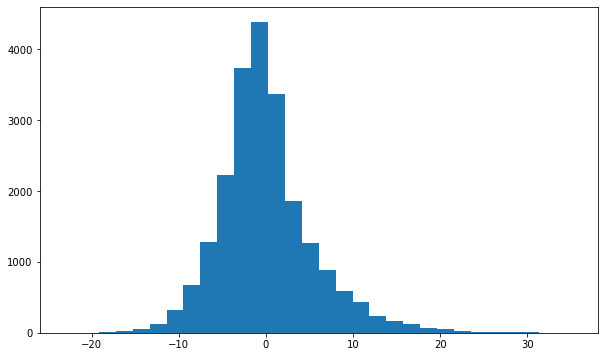

In [1164]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(residual, bins=30);

### Get Current Week Projections Ready for Model

In [1165]:
current_projections = pd.read_csv('Data/current_week_projections.csv', index_col=0)

In [1166]:
current_projections = current_projections[['Name', 'Position', 'Week', 'Opponent','Team','UpcomingOpponentPositionRank', 'FantasyPointsFanDuel', 'OperatorSalary']]
current_projections = current_projections.rename(columns={'UpcomingOpponentPositionRank':'OPRNK', 'FantasyPointsFanDuel': 'Projected', 'OperatorSalary': 'Salary'})

In [1167]:
stats_2021 = merged_data[merged_data['Year'] == '2021']

In [1168]:
stats_2021 = stats_2021[stats_2021['Week'] == (current_week-1)]

In [1169]:
stats_2021['Fantasy_PPG'] = round((stats_2021['FPPG']*(current_week-1) + stats_2021['Points_Scored']) / current_week, 1)

In [1170]:
stats_2021 = stats_2021.drop('FPPG', axis=1)

In [1171]:
stats_2021 = stats_2021.rename(columns={'Fantasy_PPG': 'FPPG'})

In [1172]:
stats_2021 = stats_2021[['Name', 'FPPG']]

In [1173]:
current_projections = current_projections.merge(stats_2021, how='inner', on=['Name'])

In [1174]:
current_projections = current_projections.drop_duplicates()

In [1175]:
betting_home = pd.read_excel('Data/clean_nfl_historic_betting_data.xlsx', sheet_name=3)
betting_data_away = pd.read_excel('Data/clean_nfl_historic_betting_data.xlsx', sheet_name=2)
betting_data = pd.concat([betting_data_home, betting_data_away])
betting_data['Date'] = betting_data['Date'].dt.year
betting_data = betting_data[betting_data['Date'] == 2021]
betting_data = betting_data[betting_data['Week'] != 0]

In [1176]:
current_projections = current_projections.merge(betting_data, how='inner', on=['Team', 'Week'])

In [1177]:
current_projections = current_projections.dropna()

In [1178]:
current_dome_teams = ['ATL', 'HOU', 'DAL', 'IND', 'ARI', 'NO', 'DET', 'MIN', 'LV', 'LAC', 'LAR']

In [1179]:
current_projections["Dome"] = np.where((current_projections['Team'].isin(current_dome_teams)) & (current_projections['Home / Away'] == "Home"), "Dome", np.where((current_projections['Opponent'].isin(current_dome_teams)) & (current_projections['Home / Away'] == "Away"), "Dome", 'Outside'))

In [1180]:
current_projections

,Name,Position,Week,Opponent,Team,OPRNK,Projected,Salary,FPPG,Date,Line Close,Total Score Close,Team Proj,Home / Away,Dome
0,Derrick Henry,RB,3,IND,TEN,13.0,18.31,9700,21.0,2021,-5.5,48.0,26.75,Home,Outside
1,Ryan Tannehill,QB,3,IND,TEN,22.0,19.69,7000,15.0,2021,-5.5,48.0,26.75,Home,Outside
2,A.J. Brown,WR,3,IND,TEN,30.0,13.98,6800,10.5,2021,-5.5,48.0,26.75,Home,Outside
3,Julio Jones,WR,3,IND,TEN,30.0,12.38,6700,8.2,2021,-5.5,48.0,26.75,Home,Outside
4,Jeremy McNichols,RB,3,IND,TEN,13.0,2.87,4700,4.7,2021,-5.5,48.0,26.75,Home,Outside
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,Tyler Kroft,TE,3,DEN,NYJ,4.0,3.93,4500,3.2,2021,10.5,41.5,15.50,Away,Outside
258,Jeff Smith,WR,3,DEN,NYJ,12.0,0.81,4500,1.3,2021,10.5,41.5,15.50,Away,Outside
259,Trevon Wesco,TE,3,DEN,NYJ,4.0,0.38,4100,0.0,2021,10.5,41.5,15.50,Away,Outside
260,Daniel Brown,TE,3,DEN,NYJ,4.0,0.13,4000,0.0,2021,10.5,41.5,15.50,Away,Outside


In [1181]:
current_projections = current_projections.rename(columns={'Line Close':'line_close', 'Total Score Close':'over_under'})
current_projections = current_projections.rename(columns={'Team Proj':'team_proj', 'Home / Away':'home_away'})

In [1182]:
current_projections['Dome'].value_counts()

Outside    211
Dome        47
Name: Dome, dtype: int64

In [1183]:
df = current_projections.copy()

In [1184]:
from sklearn.preprocessing import OrdinalEncoder
home = df[['home_away']]
encoder_home = OrdinalEncoder()
encoder_home.fit(home)
home_encoded = encoder_home.transform(home)
home_encoded = home_encoded.flatten()
df['home_away'] = home_encoded

In [1185]:
dome = df[['Dome']]
encoder_dome = OrdinalEncoder()
encoder_dome.fit(dome)
dome_encoded = encoder_dome.transform(dome)
dome_encoded = dome_encoded.flatten()
df['Dome'] = dome_encoded

In [1186]:
df = df.drop('Date', axis=1)

In [1187]:
df = df.dropna()

In [1188]:
categoricals = ['Team', 'Name','Week', 'Opponent', 'Position']
df_no_cats = df.drop(categoricals, axis=1)

In [1189]:
df_cats = df[categoricals]

In [1190]:
cat_transformed = categorical_pipeline.transform(df_cats)

In [1191]:
cat_encoded = pd.DataFrame(

    cat_transformed,

    columns=categorical_pipeline.named_steps['ohe'].get_feature_names(df_cats.columns),
 
    index=df.index
)

In [1192]:
cat_encoded

,Team_ARI,Team_ATL,Team_BAL,Team_BUF,Team_CAR,Team_CHI,Team_CIN,Team_CLE,Team_DAL,Team_DEN,...,Opponent_PIT,Opponent_SEA,Opponent_SF,Opponent_TB,Opponent_TEN,Opponent_WAS,Position_QB,Position_RB,Position_TE,Position_WR
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [1193]:
X_proj = df_no_cats[['OPRNK', 'Projected', 'FPPG', 'home_away', 'team_proj', 'Salary', 'Dome']]

In [1194]:
X_proj = pd.concat([X_proj.reset_index(drop=True), cat_encoded.reset_index(drop=True)], axis=1)

In [1195]:
X_proj['QB_proj'] = X_proj['Position_QB'] * X_proj['Projected'] * X_proj['OPRNK']
X_proj['RB_proj'] = X_proj['Position_RB'] * X_proj['Projected'] * X_proj['OPRNK']
X_proj['WR_proj'] = X_proj['Position_WR'] * X_proj['Projected'] * X_proj['OPRNK']
X_proj['TE_proj'] = X_proj['Position_TE'] * X_proj['Projected'] * X_proj['OPRNK']

In [1196]:
preds = model.predict(X_proj)

In [1197]:
current_projections['Prediction'] = np.round(preds, 1)
current_projections = current_projections[['Name', 'Position', 'Prediction']]

In [1198]:
current_projections

,Name,Position,Prediction
0,Derrick Henry,RB,18.6
1,Ryan Tannehill,QB,20.5
2,A.J. Brown,WR,14.4
3,Julio Jones,WR,12.4
4,Jeremy McNichols,RB,3.7
...,...,...,...
257,Tyler Kroft,TE,3.3
258,Jeff Smith,WR,2.6
259,Trevon Wesco,TE,3.2
260,Daniel Brown,TE,1.3


In [1199]:
current_player_list = pd.read_csv('Data/current_week_projections.csv', index_col=0)

In [1200]:
current_player_list = current_player_list[['Name', 'Position', 'Week', 'Team','UpcomingOpponentPositionRank', 'FantasyPointsFanDuel', 'OperatorSalary', 'FanShareProjectedOwnershipPercentage']]
current_player_list = current_player_list.rename(columns={'UpcomingOpponentPositionRank':'OPRNK', 'FantasyPointsFanDuel': 'Projected', 'OperatorSalary': 'Salary', 'FanShareProjectedOwnershipPercentage': 'Percentage'})

In [1201]:
current_player_list = current_player_list.merge(current_projections, how='left', on=['Name', 'Position'])

In [1202]:
current_player_list['Predictions'] = np.round(np.where(current_player_list['Prediction'].isna(), current_player_list['Projected'], current_player_list['Prediction']),1)

In [1203]:
current_player_list = current_player_list.drop('Prediction', axis =1)

In [1204]:
current_player_list = current_player_list.rename(columns={'Projected': 'FD_Projection'})

In [1205]:
current_player_list

,Name,Position,Week,Team,OPRNK,FD_Projection,Salary,Percentage,Predictions
0,Derrick Henry,RB,3,TEN,13.0,18.31,9700,20.7,18.6
1,Dalvin Cook,RB,3,MIN,31.0,18.46,9500,21.9,19.1
2,Kyler Murray,QB,3,ARI,23.0,25.96,9000,10.4,28.8
3,Patrick Mahomes,QB,3,KC,2.0,24.38,8700,12.4,27.8
4,Tyreek Hill,WR,3,KC,1.0,18.02,8700,16.7,17.7
...,...,...,...,...,...,...,...,...,...
653,Cincinnati Bengals,DST,3,CIN,NaN,5.70,3400,3.0,5.7
654,Los Angeles Chargers,DST,3,LAC,NaN,4.10,3300,0.5,4.1
655,New York Jets,DST,3,NYJ,NaN,6.40,3200,5.0,6.4
656,Jacksonville Jaguars,DST,3,JAX,NaN,4.70,3100,1.0,4.7


### Boom / Bust

In [1207]:
current_projections = df.copy()

In [1208]:
current_projections

,Name,Position,Week,Opponent,Team,OPRNK,Projected,Salary,FPPG,line_close,over_under,team_proj,home_away,Dome
0,Derrick Henry,RB,3,IND,TEN,13.0,18.31,9700,21.0,-5.5,48.0,26.75,1.0,1.0
1,Ryan Tannehill,QB,3,IND,TEN,22.0,19.69,7000,15.0,-5.5,48.0,26.75,1.0,1.0
2,A.J. Brown,WR,3,IND,TEN,30.0,13.98,6800,10.5,-5.5,48.0,26.75,1.0,1.0
3,Julio Jones,WR,3,IND,TEN,30.0,12.38,6700,8.2,-5.5,48.0,26.75,1.0,1.0
4,Jeremy McNichols,RB,3,IND,TEN,13.0,2.87,4700,4.7,-5.5,48.0,26.75,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,Tyler Kroft,TE,3,DEN,NYJ,4.0,3.93,4500,3.2,10.5,41.5,15.50,0.0,1.0
258,Jeff Smith,WR,3,DEN,NYJ,12.0,0.81,4500,1.3,10.5,41.5,15.50,0.0,1.0
259,Trevon Wesco,TE,3,DEN,NYJ,4.0,0.38,4100,0.0,10.5,41.5,15.50,0.0,1.0
260,Daniel Brown,TE,3,DEN,NYJ,4.0,0.13,4000,0.0,10.5,41.5,15.50,0.0,1.0


In [1209]:
df = merged_data.copy()

In [1210]:
df

,Name,Team,Week,Opponent,Points_Scored,Year,Position,OPRNK,Projected,Salary,Games_Played,FPPG,Date,line_close,over_under,team_proj,home_away,Dome
0,Kareem Hunt,KC,1,NE,43.10,2017,RB,3.0,10.73,6400,1,23.6,2017-09-07,8.0,47.5,19.75,Away,Outside
1,Alex Smith,KC,1,NE,31.02,2017,QB,11.0,14.69,6900,1,21.9,2017-09-07,8.0,47.5,19.75,Away,Outside
2,Tyreek Hill,KC,1,NE,23.30,2017,WR,9.0,10.48,6700,1,14.8,2017-09-07,8.0,47.5,19.75,Away,Outside
3,Charcandrick West,KC,1,NE,9.00,2017,RB,3.0,4.27,5000,1,4.6,2017-09-07,8.0,47.5,19.75,Away,Outside
4,Demetrius Harris,KC,1,NE,8.50,2017,TE,6.0,2.03,4500,1,2.5,2017-09-07,8.0,47.5,19.75,Away,Outside
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22770,Cethan Carter,MIA,2,BUF,1.30,2021,TE,10.0,0.37,4000,2,0.0,2021-09-01,3.5,47.5,22.00,Home,Outside
22771,Tua Tagovailoa,MIA,2,BUF,0.52,2021,QB,4.0,16.97,6600,2,17.2,2021-09-01,3.5,47.5,22.00,Home,Outside
22772,Mack Hollins,MIA,2,BUF,0.00,2021,WR,10.0,0.50,4500,2,0.0,2021-09-01,3.5,47.5,22.00,Home,Outside
22773,Durham Smythe,MIA,2,BUF,0.00,2021,TE,10.0,2.53,4400,2,1.4,2021-09-01,3.5,47.5,22.00,Home,Outside


In [1211]:
from sklearn.preprocessing import OrdinalEncoder
home = df[['home_away']]
encoder_home = OrdinalEncoder()
encoder_home.fit(home)
home_encoded = encoder_home.transform(home)
home_encoded = home_encoded.flatten()
df['home_away'] = home_encoded

dome = df[['Dome']]
encoder_dome = OrdinalEncoder()
encoder_dome.fit(dome)
dome_encoded = encoder_dome.transform(dome)
dome_encoded = dome_encoded.flatten()
df['Dome'] = dome_encoded

In [1212]:
df = df.dropna()

In [1213]:
df = df[df['Projected'] > 5]

In [1214]:
categoricals = ['Team', 'Name', 'Week', 'Opponent', 'Position']
df_no_cats = df.drop(categoricals, axis=1)

In [1215]:
df['Boom/Bust'] = df['Points_Scored'] - df['Projected']

In [1216]:
def boom_bust(score):
    if score < -4:
        return "Bust"
    elif score > -4 and score < 4:
        return "Neutral"
    else:
        return "Boom"

In [1217]:
df['Boom/Bust'] = df['Boom/Bust'].apply(boom_bust) 

In [1218]:
df['Boom/Bust'].value_counts(normalize=True)

Neutral    0.454598
Bust       0.303867
Boom       0.241535
Name: Boom/Bust, dtype: float64

In [1219]:
X = df.drop('Boom/Bust', axis=1)

In [1220]:
X = X.drop('Points_Scored', axis=1)

In [1221]:
X = X.drop(columns=['Date', 'Games_Played', 'Year'], axis=1)

In [1222]:
y = df['Boom/Bust']

In [1223]:
current_projections = current_projections[X.columns]

In [1224]:
current_projections

,Name,Team,Week,Opponent,Position,OPRNK,Projected,Salary,FPPG,line_close,over_under,team_proj,home_away,Dome
0,Derrick Henry,TEN,3,IND,RB,13.0,18.31,9700,21.0,-5.5,48.0,26.75,1.0,1.0
1,Ryan Tannehill,TEN,3,IND,QB,22.0,19.69,7000,15.0,-5.5,48.0,26.75,1.0,1.0
2,A.J. Brown,TEN,3,IND,WR,30.0,13.98,6800,10.5,-5.5,48.0,26.75,1.0,1.0
3,Julio Jones,TEN,3,IND,WR,30.0,12.38,6700,8.2,-5.5,48.0,26.75,1.0,1.0
4,Jeremy McNichols,TEN,3,IND,RB,13.0,2.87,4700,4.7,-5.5,48.0,26.75,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,Tyler Kroft,NYJ,3,DEN,TE,4.0,3.93,4500,3.2,10.5,41.5,15.50,0.0,1.0
258,Jeff Smith,NYJ,3,DEN,WR,12.0,0.81,4500,1.3,10.5,41.5,15.50,0.0,1.0
259,Trevon Wesco,NYJ,3,DEN,TE,4.0,0.38,4100,0.0,10.5,41.5,15.50,0.0,1.0
260,Daniel Brown,NYJ,3,DEN,TE,4.0,0.13,4000,0.0,10.5,41.5,15.50,0.0,1.0


In [1225]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=42)

In [1226]:
X_train

,Name,Team,Week,Opponent,Position,OPRNK,Projected,Salary,FPPG,line_close,over_under,team_proj,home_away,Dome
21038,Tyreek Hill,KC,14,MIA,WR,15.0,17.53,9000,20.3,-7.0,51.5,29.25,0.0,1.0
5384,Latavius Murray,MIN,2,GB,RB,10.0,5.73,5500,4.2,-2.0,45.5,23.75,0.0,1.0
5088,Andy Dalton,CIN,1,IND,QB,23.0,17.87,6800,19.4,-1.0,47.5,24.25,0.0,0.0
13228,Kyler Murray,ARI,9,SF,QB,2.0,16.03,7200,18.4,10.0,43.0,16.50,1.0,0.0
2361,Le'Veon Bell,PIT,10,IND,RB,25.0,20.50,9400,19.1,-10.5,47.0,28.75,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12601,Gerald Everett,LAR,7,ATL,TE,24.0,7.05,5900,6.5,-3.0,54.5,28.75,0.0,0.0
11417,Christian Kirk,ARI,3,CAR,WR,12.0,10.99,5900,11.4,-2.5,45.5,24.00,1.0,0.0
11844,Julian Edelman,NE,4,BUF,WR,4.0,11.67,6900,12.1,-7.0,41.5,24.25,0.0,1.0
1795,Coby Fleener,NO,6,DET,TE,21.0,6.80,5100,7.6,-6.0,50.5,28.25,1.0,0.0


In [1227]:
numericals = ['OPRNK', 'Projected', 'Salary', 'FPPG', 'team_proj', 'home_away', 'Dome']

X_train_num = X_train[numericals]
X_test_num = X_test[numericals]
current_projections_num = current_projections[numericals]

for col in X_train_num:
    X_train_num[col] = X_train_num[col].astype('float64')

for col in X_test_num:
    X_test_num[col] = X_test_num[col].astype('float64')
    
for col in current_projections_num:
    current_projections_num[col] = current_projections[col].astype('float64')

<ipython-input-1227-ffe09ac39252>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_num[col] = X_train_num[col].astype('float64')
<ipython-input-1227-ffe09ac39252>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_num[col] = X_test_num[col].astype('float64')
<ipython-input-1227-ffe09ac39252>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [1228]:
categoricals = ['Week', 'Position', 'Team']

In [1229]:
X_train_cat = X_train[categoricals]
X_test_cat = X_test[categoricals]
curret_projections_cat = current_projections[categoricals]

In [1230]:

#Create numerical pipeline
numerical_pipeline = Pipeline(steps=[
    ('ss', StandardScaler())
])
 #Create categorical pipeline               
categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(categories='auto',
                          drop='first',
                          sparse=False))
])
#Pass the pipelines into ColumnTransformer on the training data
trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, X_train_num.columns),
    ('categorical', categorical_pipeline, X_train_cat.columns)
])

In [1231]:
base_pipe_lr = Pipeline([('trans', trans),
                    ('LR', LogisticRegression(random_state=42))])

base_pipe_dt = Pipeline([('trans', trans),
                    ('DT', DecisionTreeClassifier(random_state=42))])

base_pipe_rf = Pipeline([('trans', trans),
                    ('RF', RandomForestClassifier(random_state=42))])

base_pipe_knn = Pipeline([('trans', trans),
                    ('KNN', KNeighborsClassifier())])

base_pipe_svm = Pipeline([('trans', trans),
                     ('SVM', svm.SVC(random_state=42))])

In [1232]:
base_pipes = [base_pipe_lr, base_pipe_dt, base_pipe_rf, base_pipe_knn, base_pipe_svm]

In [1233]:
start = time.time()

for pipe in base_pipes:
    pipe.fit(X_train,y_train)
    
end = time.time()
print('Time it took to run the fittings: {}'.format(round(end-start),0) + ' seconds')

Time it took to run the fittings: 11 seconds


In [1234]:
grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees', 
             2: 'Random Forest', 3: 'K-Nearest Neighbors', 
             4: 'Support Vector Machines'}

In [1235]:
for i, model in enumerate(base_pipes):
    print('{} Testing Accuracy: {}'.format(grid_dict[i], model.score(X_test,y_test)))

Logistic Regression Testing Accuracy: 0.45402077722200845
Decision Trees Testing Accuracy: 0.37322046941131204
Random Forest Testing Accuracy: 0.43747595228934205
K-Nearest Neighbors Testing Accuracy: 0.3662947287418238
Support Vector Machines Testing Accuracy: 0.46556367833782225


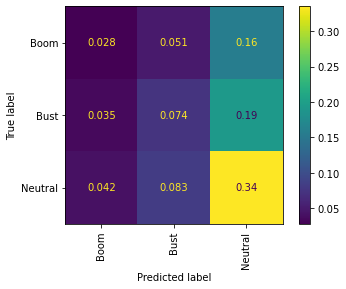

In [1236]:
plot_confusion_matrix(base_pipe_rf, X_test, y_test, xticks_rotation='vertical', normalize='all');

### Hyper Parameter Tuning

In [1237]:
hyper_pipe_rf = imbPipeline([('trans', trans),
                     ('smote', SMOTE(random_state=42)),
                     ('RF', RandomForestClassifier(random_state=42))])

hyper_pipe_lr = imbPipeline([('trans', trans),
                     ('smote', SMOTE(random_state=42)),
                     ('LR', LogisticRegression(random_state=42))])

In [1238]:
#Random Forest hyperparameters
min_samples_split = [4,6,8]
n_estimators = [1000]

#Create grid
rf_param_grid = [{'RF__min_samples_split': min_samples_split,
                   'RF__n_estimators': n_estimators}]

#Random Forest hyperparameters
penalty = ['l1', 'l2']
C = np.logspace(-4, 4, 20)

#Create grid
lr_param_grid = [{'LR__penalty': penalty,
                   'LR__C': C}]

In [1239]:
rf_grid_search = GridSearchCV(estimator=hyper_pipe_rf,
        param_grid=rf_param_grid,
        scoring='precision_macro',
        cv=2,
        n_jobs=-1)

lr_grid_search = GridSearchCV(estimator=hyper_pipe_lr,
        param_grid=lr_param_grid,
        scoring='precision_macro',
        cv=2,
        n_jobs=-1)

In [1240]:
hyper_grids = [rf_grid_search, lr_grid_search]

In [1241]:
hyper_grid_dict = {0: 'Random Forest', 1:'Logistic Regression'}

In [1242]:
start = time.time()

for pipe in hyper_grids:
    pipe.fit(X_train,y_train)
    
end = time.time()
print('Time it took to run the fittings: {}'.format(round(end-start),0) + ' seconds')

Time it took to run the fittings: 85 seconds


In [1243]:
for i, model in enumerate(hyper_grids):
    print('{} Validation Accuracy: {}'.format(hyper_grid_dict[i], model.score(X_test,y_test)))
    print('{} Best Params: {}'.format(hyper_grid_dict[i], model.best_params_))

Random Forest Validation Accuracy: 0.3634542548959014
Random Forest Best Params: {'RF__min_samples_split': 8, 'RF__n_estimators': 1000}
Logistic Regression Validation Accuracy: 0.380787432186511
Logistic Regression Best Params: {'LR__C': 0.0018329807108324356, 'LR__penalty': 'l2'}


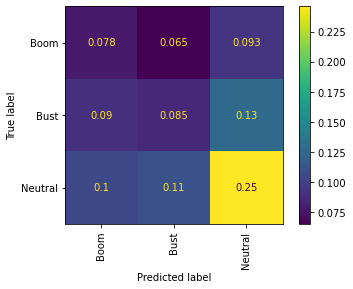

In [1244]:
plot_confusion_matrix(lr_grid_search, X_test, y_test, xticks_rotation='vertical', normalize='all');

In [1245]:
print(classification_report(y_test, rf_grid_search.predict(X_test)))

              precision    recall  f1-score   support

        Boom       0.28      0.19      0.23       615
        Bust       0.32      0.29      0.31       788
     Neutral       0.49      0.60      0.54      1196

    accuracy                           0.41      2599
   macro avg       0.36      0.36      0.36      2599
weighted avg       0.39      0.41      0.39      2599



In [1246]:
current_projections

,Name,Team,Week,Opponent,Position,OPRNK,Projected,Salary,FPPG,line_close,over_under,team_proj,home_away,Dome
0,Derrick Henry,TEN,3,IND,RB,13.0,18.31,9700,21.0,-5.5,48.0,26.75,1.0,1.0
1,Ryan Tannehill,TEN,3,IND,QB,22.0,19.69,7000,15.0,-5.5,48.0,26.75,1.0,1.0
2,A.J. Brown,TEN,3,IND,WR,30.0,13.98,6800,10.5,-5.5,48.0,26.75,1.0,1.0
3,Julio Jones,TEN,3,IND,WR,30.0,12.38,6700,8.2,-5.5,48.0,26.75,1.0,1.0
4,Jeremy McNichols,TEN,3,IND,RB,13.0,2.87,4700,4.7,-5.5,48.0,26.75,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,Tyler Kroft,NYJ,3,DEN,TE,4.0,3.93,4500,3.2,10.5,41.5,15.50,0.0,1.0
258,Jeff Smith,NYJ,3,DEN,WR,12.0,0.81,4500,1.3,10.5,41.5,15.50,0.0,1.0
259,Trevon Wesco,NYJ,3,DEN,TE,4.0,0.38,4100,0.0,10.5,41.5,15.50,0.0,1.0
260,Daniel Brown,NYJ,3,DEN,TE,4.0,0.13,4000,0.0,10.5,41.5,15.50,0.0,1.0


In [1250]:
current_projections['Boom/Bust'] = lr_grid_search.predict(current_projections)

/Users/kevinmcdonough/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
<ipython-input-1250-96ea43941381>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_projections['Boom/Bust'] = lr_grid_search.predict(current_projections)


In [1251]:
current_projections

,Name,Team,Week,Opponent,Position,OPRNK,Projected,Salary,FPPG,line_close,over_under,team_proj,home_away,Dome,Boom/Bust
0,Derrick Henry,TEN,3,IND,RB,13.0,18.31,9700,21.0,-5.5,48.0,26.75,1.0,1.0,Boom
1,Ryan Tannehill,TEN,3,IND,QB,22.0,19.69,7000,15.0,-5.5,48.0,26.75,1.0,1.0,Boom
2,A.J. Brown,TEN,3,IND,WR,30.0,13.98,6800,10.5,-5.5,48.0,26.75,1.0,1.0,Bust
3,Julio Jones,TEN,3,IND,WR,30.0,12.38,6700,8.2,-5.5,48.0,26.75,1.0,1.0,Bust
4,Jeremy McNichols,TEN,3,IND,RB,13.0,2.87,4700,4.7,-5.5,48.0,26.75,1.0,1.0,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,Tyler Kroft,NYJ,3,DEN,TE,4.0,3.93,4500,3.2,10.5,41.5,15.50,0.0,1.0,Neutral
258,Jeff Smith,NYJ,3,DEN,WR,12.0,0.81,4500,1.3,10.5,41.5,15.50,0.0,1.0,Neutral
259,Trevon Wesco,NYJ,3,DEN,TE,4.0,0.38,4100,0.0,10.5,41.5,15.50,0.0,1.0,Neutral
260,Daniel Brown,NYJ,3,DEN,TE,4.0,0.13,4000,0.0,10.5,41.5,15.50,0.0,1.0,Neutral


In [1253]:
current_projections = current_projections[['Name', 'Team', 'Boom/Bust']]

In [1254]:
current_player_list = current_player_list.merge(current_projections, how ='left', on=['Name', 'Team'])

In [1256]:
current_player_list.to_csv('current_projections.csv')